# Visualization by flipping

Flipping the top pixels and see how much accuracy it lasts and it imputes

First, we visualize by plotting original images and a scaling image.

In [32]:
%matplotlib inline
import torch
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

import exp.utils_visualise as utils_visualise
import matplotlib.pyplot as plt
import numpy as np
from exp.loaddata_utils import ImageNetLoadClass
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import rc
import matplotlib.pylab as plt
from arch.DeepLiftNet import DeepLiftNet
from exp.vbd_imagenet.nets.Inpainting.Baseline import MeanInpainter

def get_file_names(directory):
    directory = os.path.join('../result', directory)
    result = []
    for filename in os.listdir(directory):
        if filename.endswith("records.th"): 
            result.append(filename)
    return result

def sort_asd_2d(nd_arr):
    ''' (np arr) -> tuple
    Sort 2d array and return an order by ascending order
    :param nd_arr
    :return: a tuple of array of index. first element is index 1, 2nd element is index 2.
    '''
    return np.unravel_index(np.argsort(nd_arr.ravel()), nd_arr.shape)

def mask_gen_to_flip_top_pixels(importance_2d, num_pixels):
    rank = sort_asd_2d(-importance_2d)

    H, W = importance_2d.shape
    mask = torch.ones(1, 1, H, W)

    for i in xrange(num_pixels[-1] + 1):
        mask[0, 0, rank[0][i], rank[1][i]] = 0.
        if i in num_pixels:
            yield mask

def mask_gen_to_keep_top_pixels(importance_2d, num_pixels):
    rank = sort_asd_2d(importance_2d)

    H, W = importance_2d.shape
    mask = torch.ones(1, 1, H, W)

    for i in xrange(num_pixels[-1] + 1):
        mask[0, 0, rank[0][i], rank[1][i]] = 0.
        if (i + 1) in num_pixels:
            yield mask

def get_log_odds_ratio(image, from_class=8, to_class=3):
    if image.ndimension() == 3:
        image = image.unsqueeze(0)
    pre_softmax_score = interpret_net.forward(Variable(image, volatile=True))
    
    logodds_diff = pre_softmax_score[:, from_class] - pre_softmax_score[:, to_class]
    return logodds_diff.data[0]

In [43]:
# Load mnist classifier
label_arrs = [
    ('Perturbation', '../result/1013-p_b/8_3_0_records.th'),
    ('Variational\nDropout\n($\lambda=0.1$)', '../result/1013-vbd_l1_opposite-0.1/8_0_records.th'),
    ('Variational\nDropout\n($\lambda=1E-3$)', '../result/1013-vbd_l1_opposite-1E-3/8_0_records.th'),
    ('Variational\nDropout\n($\lambda=1E-6$)', '../result/1013-vbd_l1_opposite-1E-6/8_0_records.th'),
]

In [16]:
# Load classifier.
impant_model = MeanInpainter()

interpret_net = DeepLiftNet()
interpret_net.load_state_dict(torch.load('../model/mnist_cnn_allconv_pytorch'))
interpret_net.eval()
interpret_net.float()
interpret_net.eval()
print 'Loaded classifier successful!'

Loaded classifier successful!


In [ ]:
# Start drawing. Open each path and plot something!
num_pixels = [50, 100, 150]

N = len(label_arrs)
print 'N:', N

fig, axes = plt.subplots(N, 2 + len(num_pixels) + 2, figsize=(len(num_pixels) * 4, N * 4))

for img_idx, (name, path) in enumerate(label_arrs):
    orig_log_odds, all_log_odds, unnormalized_img, imp_vector, random_odds = torch.load(path)

    overlayed_img, clim = utils_visualise.get_overlayed_image(unnormalized_img[0, ...], imp_vector)

    # Plot original image and the colored image
#     utils_visualise.save_figs([overlayed_img], filename=file_name, visualize=False, nrow=1,
#                               clim=clim, ax=axes])
    im1 = utils_visualise.plot_pytorch_img(unnormalized_img[0, ...].expand(3, 28, 28), axes[img_idx, 0])
    im2 = utils_visualise.plot_pytorch_img(overlayed_img, axes[img_idx, 1])

    orig_log_odds = get_log_odds_ratio(unnormalized_img, from_class=8, to_class=3)

    axes[img_idx, 0].set_xlabel('%.1f' % (orig_log_odds), fontsize=20)
    axes[img_idx, 0].set_ylabel(name, fontsize=20)
    if img_idx == 0:
        axes[img_idx, 1].set_title('Importance', fontsize=20)

    # Plot the mask image
#     num_pixels = [int(perc * 28 * 28) for perc in percs]
    mask_generator = iter(mask_gen_to_flip_top_pixels(imp_vector, num_pixels))

    for idx, num_pixel in enumerate(num_pixels):
        mask = mask_generator.next()

        regenerated = impant_model.impute_missing_imgs(unnormalized_img, mask)

        log_odds = get_log_odds_ratio(regenerated, from_class=8, to_class=3)

#         utils_visualise.plot_pytorch_img(mask[0, ...].expand(3, 224, 224), axes[img_idx, 2 + 2 * idx])
        utils_visualise.plot_pytorch_img(regenerated[0, ...].expand(3, 28, 28), axes[img_idx, 2 + idx])

        axes[img_idx, 2 + idx].set_xlabel('%.1f' % (log_odds), fontsize=20)
        if img_idx == 0:
#             axes[img_idx, 1 + 2 * idx].set_title('%d mask' %(num_pixel), fontsize=20)
            axes[img_idx, 2 + idx].set_title('%d imputed' % (num_pixel), fontsize=20)
    
    if 'p_b' not in name:
        axes[img_idx, -2].

# Closes all the axis    
for ax1 in axes:
    for ax in ax1:
        ax.set_xticks([], [])
        ax.set_yticks([], [])
print 'Done!'
# return fig

N: 4
Done!


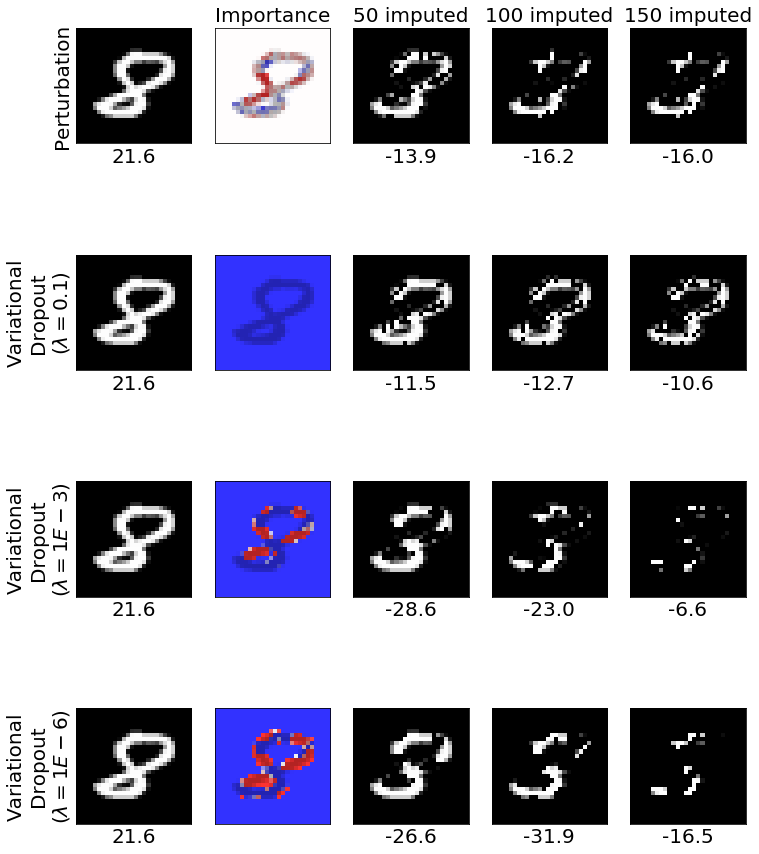

In [46]:
# Start drawing. Open each path and plot something!
num_pixels = [50, 100, 150]

N = len(label_arrs)
print 'N:', N

fig, axes = plt.subplots(N, 2 + len(num_pixels) + 2, figsize=(len(num_pixels) * 4, N * 4))

for img_idx, (name, path) in enumerate(label_arrs):
    orig_log_odds, all_log_odds, unnormalized_img, imp_vector, random_odds = torch.load(path)

    overlayed_img, clim = utils_visualise.get_overlayed_image(unnormalized_img[0, ...], imp_vector)

    # Plot original image and the colored image
#     utils_visualise.save_figs([overlayed_img], filename=file_name, visualize=False, nrow=1,
#                               clim=clim, ax=axes])
    im1 = utils_visualise.plot_pytorch_img(unnormalized_img[0, ...].expand(3, 28, 28), axes[img_idx, 0])
    im2 = utils_visualise.plot_pytorch_img(overlayed_img, axes[img_idx, 1])

    orig_log_odds = get_log_odds_ratio(unnormalized_img, from_class=8, to_class=3)

    axes[img_idx, 0].set_xlabel('%.1f' % (orig_log_odds), fontsize=20)
    axes[img_idx, 0].set_ylabel(name, fontsize=20)
    if img_idx == 0:
        axes[img_idx, 1].set_title('Importance', fontsize=20)

    # Plot the mask image
#     num_pixels = [int(perc * 28 * 28) for perc in percs]
    mask_generator = iter(mask_gen_to_flip_top_pixels(imp_vector, num_pixels))

    for idx, num_pixel in enumerate(num_pixels):
        mask = mask_generator.next()

        regenerated = impant_model.impute_missing_imgs(unnormalized_img, mask)

        log_odds = get_log_odds_ratio(regenerated, from_class=8, to_class=3)

#         utils_visualise.plot_pytorch_img(mask[0, ...].expand(3, 224, 224), axes[img_idx, 2 + 2 * idx])
        utils_visualise.plot_pytorch_img(regenerated[0, ...].expand(3, 28, 28), axes[img_idx, 2 + idx])

        axes[img_idx, 2 + idx].set_xlabel('%.1f' % (log_odds), fontsize=20)
        if img_idx == 0:
#             axes[img_idx, 1 + 2 * idx].set_title('%d mask' %(num_pixel), fontsize=20)
            axes[img_idx, 2 + idx].set_title('%d imputed' % (num_pixel), fontsize=20)
    
    if 'p_b' not in name:
        axes[img_idx, -2].

# Closes all the axis    
for ax1 in axes:
    for ax in ax1:
        ax.set_xticks([], [])
        ax.set_yticks([], [])
print 'Done!'
# return fig

In [2]:
# Load imagenet helper
loadhelper = ImageNetLoadClass('../../imagenet/', dataset='valid/')

def plot_imgs_given_path(label_arrs, percs=[0.005, 0.02, 0.1], impant_model=None, interpret_net=None,
                         mask_mode=mask_gen_to_flip_top_pixels):
    # Load impant model. Default is AE.
    if impant_model is None:
        impant_model = ImpantingModel()
        states = torch.load('../checkpts/0903-all-masks_lr_0.0005_epochs_99', 
                            map_location=lambda storage, loc: storage)
        impant_model.load_state_dict(states['state_dict'])
        impant_model.eval()
        print 'Loaded impant model successful!'
    
    # Load classifier. Default is AlexNet
    if interpret_net is None:
        interpret_net = models.alexnet(pretrained=True)
        interpret_net.eval()
        print 'Loaded classifier successful!'
    
    # Start drawing. Open each path and plot something!
    N = len(label_arrs)
    print 'N:', N
    
    fig, axes = plt.subplots(N, 8, figsize=(30, N * 4))
    
    for img_idx, (name, path) in enumerate(label_arrs):
        orig_log_odds, all_log_odds, unnormalized_img, imp_vector = torch.load(path)
        orig_img = ImageNetLoadClass.normalize_imagenet_img(unnormalized_img.unsqueeze(0))

        overlayed_img, clim = utils_visualise.get_overlayed_image(unnormalized_img, imp_vector)

        # Plot original image and the colored image
        im1 = utils_visualise.plot_pytorch_img(unnormalized_img, axes[img_idx, 0])
        im2 = utils_visualise.plot_pytorch_img(overlayed_img, axes[img_idx, 1])

        prob, pred_class_name, target_class = get_prob_and_pred_class_name(orig_img)
        log_odds = np.log(prob) - np.log(1. - prob)

        axes[img_idx, 0].set_title(pred_class_name, fontsize=20)
        axes[img_idx, 0].set_xlabel('%.1f%% (%.1f)' % (prob * 100, log_odds), fontsize=20)
        axes[img_idx, 0].set_ylabel(name, fontsize=20)
        if img_idx == 0:
            axes[img_idx, 1].set_title('Importance', fontsize=20)

        # Plot the mask image
        num_pixels = [int(perc * 224 * 224) for perc in percs]
        mask_generator = iter(mask_mode(imp_vector, num_pixels))

        for idx, key in enumerate(percs):
            mask = mask_generator.next()

            regenerated = impant_model.impute_missing_imgs(orig_img, mask)
            regenerated = ImageNetLoadClass.unnormalize_imagenet_img(regenerated)

            prob, _, _ = get_prob_and_pred_class_name(regenerated, target_class)
            log_odds = np.log(prob) - np.log(1. - prob)

            utils_visualise.plot_pytorch_img(mask[0, ...].expand(3, 224, 224), axes[img_idx, 2 + 2 * idx])
            utils_visualise.plot_pytorch_img(regenerated[0, ...], axes[img_idx, 3 + 2 * idx])
            
            axes[img_idx, 3 + 2 * idx].set_xlabel('%.1f%% (%.1f)' % (prob * 100, log_odds), fontsize=20)
            if img_idx == 0:
                axes[img_idx, 2 + 2 * idx].set_title('%.1f%% mask' %(key * 100), fontsize=20)
                axes[img_idx, 3 + 2 * idx].set_title('%.1f%% imputed' % (key * 100), fontsize=20)
    
    # Closes all the axis    
    for ax1 in axes:
        for ax in ax1:
            ax.set_xticks([], [])
            ax.set_yticks([], [])
    print 'Done!'
    return fig


## Cache the impant and classifier 

In [6]:
from exp.vbd_imagenet.nets.Inpainting.AE_Inpainting import ImpantingModel
from exp.vbd_imagenet.nets.Inpainting.AE_Inpainting import VAEImpantModel, VAEWithVarImpantModelMean
from exp.vbd_imagenet.nets.Inpainting.GAN_Inpainting import AE_GAN
from exp.vbd_imagenet.nets.GAN.GAN_G import GAN_G
from exp.vbd_imagenet.nets.BVLC.BVLC_NET import BVLC_NET, ImpaintBVLC
from exp.vbd_imagenet.nets.Inpainting.Baseline import LocalMeanInpainter, MeanInpainter

def loadMeanInpainter():
    return MeanInpainter()

def loadLocalMeanInpainter():
    generative_model = LocalMeanInpainter()
    return generative_model

def loadAE():
    generative_model = ImpantingModel()
    states = torch.load('../checkpts/0903-all-masks_lr_0.0005_epochs_99', map_location=lambda storage, loc: storage)
    state_dict = generative_model.state_dict()
    state_dict.update(states['state_dict'])
    generative_model.load_state_dict(state_dict)
    generative_model.eval()

    print 'Load generative model'
    return generative_model

def loadVAE():
    generative_model = VAEImpantModel()
    states = torch.load('../checkpts/0905-vae_lr_0.0005_epochs_99', map_location=lambda storage, loc: storage)
    state_dict = generative_model.state_dict()
    state_dict.update(states['state_dict'])
    generative_model.load_state_dict(state_dict)
    generative_model.eval()

    print 'Load generative model'
    return generative_model

def loadVAEWithCovMean():
    generative_model = VAEWithVarImpantModelMean()
    states = torch.load('../checkpts2/0922-VAEWithVar_lr_0.0005_epochs_53', map_location=lambda storage, loc: storage)
    state_dict = generative_model.state_dict()
    state_dict.update(states['state_dict'])
    generative_model.load_state_dict(state_dict)
    generative_model.eval()

    print 'Load generative model'
    return generative_model

def loadGANAE():
    generative_model = AE_GAN(bvlc_dir='../nets/BVLC/', gan_g_dir='../nets/GAN/', clamp=False)
    states = torch.load('../checkpts2/0917-AEGAN-2_lr_0.0002_epochs_153', map_location=lambda storage, loc: storage)
#     state_dict = generative_model.state_dict()
#     state_dict.update(states['state_dict'])
    generative_model.load_state_dict(states['state_dict'])
    generative_model.eval()

    print 'Load generative model'
    return generative_model

def loadGAN_optimize():
    states = torch.load('../checkpts2/0917-AEGAN-2_lr_0.0002_epochs_153', map_location=lambda storage, loc: storage)
    bvlc_net = ImpaintBVLC()
    bvlc_net.load_state_dict(states['state_dict'])

    impant_model = GAN_G(lr=0.3, steps=30, step_print=30, lookahead=20,
                         bound='../nets/GAN/fc6.txt', encoder=bvlc_net, clamp=False,
                         use_existing_code=False)
    state = impant_model.state_dict()
    state.update(torch.load('../nets/GAN/GAN_G.pth', map_location=lambda storage, loc: storage))
    impant_model.load_state_dict(state)
    impant_model.eval()
    return impant_model

## Load Alexnet as my classifier

In [4]:
interpret_net = models.alexnet(pretrained=True)
interpret_net.eval()

print 'Loaded successful!'

Loaded successful!


## Visualize Mean
Compare between p_b and vbd.

In [ ]:
label_arrs = [
    ('Perturbation', '../imgs/val_benchmark/0925_mean_p_b_val/ILSVRC2012_val_00000962_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_mean_vbd_0.1_p0.5_val/ILSVRC2012_val_00000962_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_mean_p_b_val/ILSVRC2012_val_00000963_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_mean_vbd_0.1_p0.5_val/ILSVRC2012_val_00000963_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_mean_p_b_val/ILSVRC2012_val_00000978_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_mean_vbd_0.1_p0.5_val/ILSVRC2012_val_00000978_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_mean_p_b_val/ILSVRC2012_val_00000994_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_mean_vbd_0.1_p0.5_val/ILSVRC2012_val_00000994_records.th'),
]

mean_model = loadMeanInpainter()

fig = plot_imgs_given_path(label_arrs, impant_model=mean_model, interpret_net=interpret_net)
fig.savefig('mean_prior0.5_val.eps', format='eps', dpi=500, bbox_inches='tight')

## Visualize Local
Compare between p_b and vbd.

In [ ]:
label_arrs = [
    ('Perturbation', '../imgs/val_benchmark/0925_local_p_b_val/ILSVRC2012_val_00000962_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_local_vbd_0.1_p0.5_val/ILSVRC2012_val_00000962_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_local_p_b_val/ILSVRC2012_val_00000963_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_local_vbd_0.1_p0.5_val/ILSVRC2012_val_00000963_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_local_p_b_val/ILSVRC2012_val_00000978_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_local_vbd_0.1_p0.5_val/ILSVRC2012_val_00000978_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0925_local_p_b_val/ILSVRC2012_val_00000994_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0925_local_vbd_0.1_p0.5_val/ILSVRC2012_val_00000994_records.th'),
]

local_model = loadLocalMeanInpainter()

fig = plot_imgs_given_path(label_arrs, impant_model=local_model, interpret_net=interpret_net)
fig.savefig('local_prior0.5_val.eps', format='eps', dpi=500, bbox_inches='tight')

## Visualize AE
Compare between p_b and vbd.

In [ ]:
label_arrs = [
    ('Perturbation', '../imgs/val_benchmark/0915_ae_p_b_val/ILSVRC2012_val_00000962_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0915_ae_vbd_0.1_prior_0.5_val/ILSVRC2012_val_00000962_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0915_ae_p_b_val/ILSVRC2012_val_00000963_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0915_ae_vbd_0.1_prior_0.5_val/ILSVRC2012_val_00000963_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0915_ae_p_b_val/ILSVRC2012_val_00000978_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0915_ae_vbd_0.1_prior_0.5_val/ILSVRC2012_val_00000978_records.th'),
    ('Perturbation', '../imgs/val_benchmark/0915_ae_p_b_val/ILSVRC2012_val_00000994_records.th'),
    ('Variational\nDropout', '../imgs/val_benchmark/0915_ae_vbd_0.1_prior_0.5_val/ILSVRC2012_val_00000994_records.th'),
]

ae_model = loadAE()

fig = plot_imgs_given_path(label_arrs, impant_model=ae_model, interpret_net=interpret_net)
fig.savefig('ae_prior0.5_val.eps', format='eps', dpi=500, bbox_inches='tight')

## Visualize VAE

# Compare between generative model

In [16]:
def load_img_and_overlay(path):
    orig_log_odds, all_log_odds, unnormalized_img, imp_vector = torch.load(path)
    orig_img = ImageNetLoadClass.normalize_imagenet_img(unnormalized_img.unsqueeze(0))

    overlayed_img, clim = utils_visualise.get_overlayed_image(unnormalized_img, imp_vector)
    return unnormalized_img, overlayed_img, orig_img

def compare_generative_model(filenames, methods):
#     folders = [['val_benchmark/0925_mean_p_b_val', 'val_benchmark/0925_local_p_b_val', 
#                 'val_benchmark/0915_ae_p_b_val', 'val_benchmark/0916_vae_p_b_s1_val', 
#                 'val_benchmark/0925_vae_cov_mean_p_b_val',
#                 'val_benchmark/0919_aegan_p_b_val'],
#                ['val_benchmark/0925_mean_vbd_0.1_p0.5_val', 'val_benchmark/0925_local_vbd_0.1_p0.5_val', 
#                 'val_benchmark/0915_ae_vbd_0.1_prior_0.5_val', 'val_benchmark/0918_vae_vbd_0.1_prior_0.5_val', 
#                 'val_benchmark/0925_vae_cov_mean_vbd_0.1_p0.5_val',
#                 'val_benchmark/0919_aegan_vbd_0.1_p0.5_val']]
    N = len(filenames)
    print 'N:', N
    
    fig, axes = plt.subplots(2 * N, 1 + len(methods), figsize=(6 * len(methods), 12 * N))
    
    folders = methods.values()
    names = methods.keys()
    for i in xrange(1, 1 + len(methods)):
        axes[0, i].set_title(names[i - 1], fontsize=24)
        
#     axes[0, 1].set_title('Mean', fontsize=24)
#     axes[0, 2].set_title('Local (15)', fontsize=24)
#     axes[0, 3].set_title('Autoencoder', fontsize=24)
#     axes[0, 4].set_title('Varitional\nAutoencoder', fontsize=24)
#     axes[0, 5].set_title('Varitional\nAutoencoder\nCovariance', fontsize=24)
#     axes[0, 6].set_title('Denoise\nGAN', fontsize=24)
    
    for idx, filename in enumerate(filenames):
        path = os.path.join('../imgs', folders[0][0], '%s_records.th' % filename)
        unnormalized_img, overlayed_img, orig_img = load_img_and_overlay(path)
        prob, pred_class_name, target_class = get_prob_and_pred_class_name(orig_img)
        axes[2 * idx, 0].set_title(pred_class_name, fontsize=24)
        
        utils_visualise.plot_pytorch_img(unnormalized_img, axes[2 * idx + 0, 0])
        utils_visualise.plot_pytorch_img(unnormalized_img, axes[2 * idx + 1, 0])
        axes[2 * idx + 0, 0].set_ylabel('Perturbation', fontsize=24)
        axes[2 * idx + 1, 0].set_ylabel('Variational\nDropout', fontsize=24)

        for i in xrange(2):
            for j in xrange(1, len(folders) + 1):
                path = os.path.join('../imgs', folders[j - 1][i], '%s_records.th' % filename)
                _, overlayed_img, _ = load_img_and_overlay(path)

                utils_visualise.plot_pytorch_img(overlayed_img, axes[2 * idx + i, j])

    for ax1 in axes:
        for ax in ax1:
            ax.set_xticks([], [])
            ax.set_yticks([], [])
    return fig

In [ ]:
from collections import OrderedDict
methods = OrderedDict([
    ('Mean', ('val_benchmark/0925_mean_p_b_val', 'val_benchmark/0925_mean_vbd_0.1_p0.5_val')),
    ('Local (15)', ('val_benchmark/0925_local_p_b_val', 'val_benchmark/0925_local_vbd_0.1_p0.5_val')),
    ('Autoencoder', ('val_benchmark/0915_ae_p_b_val', 'val_benchmark/0915_ae_vbd_0.1_prior_0.5_val')),
    ('Varitional\nAutoencoder', ('val_benchmark/0916_vae_p_b_s1_val', 'val_benchmark/0918_vae_vbd_0.1_prior_0.5_val')),
    ('Varitional\nAutoencoder\nCovariance', ('val_benchmark/0925_vae_cov_mean_p_b_val', 
                                             'val_benchmark/0925_vae_cov_mean_vbd_0.1_p0.5_val')),
    ('Denoise\nGAN', ('val_benchmark/0919_aegan_p_b_val', 'val_benchmark/0919_aegan_vbd_0.1_p0.5_val')),
])
files = ['ILSVRC2012_val_00000064', 'ILSVRC2012_val_00000225', 
         'ILSVRC2012_val_00000236', 'ILSVRC2012_val_00000307']

fig = compare_generative_model(files, methods)
fig.savefig('compare_gen_model.eps', format='eps', dpi=500, bbox_inches='tight')